## Imports and Loading Datasets

In [ ]:
!pip install alibi[tensorflow]

In [ ]:
%matplotlib inline

# imports
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score
from alibi.explainers import IntegratedGradients
from alibi.utils import visualize_image_attr
import matplotlib.pyplot as plt
import random
import cv2

# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

# Check the shape of the dataset
print(f"\nx_train shape: {x_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape}")
print(f"y_test shape: {y_test.shape}")

170498071/170498071 [==============================] - 11s 0us/step

x_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


## Training CNN Model Using Keras

In [ ]:
# CIFAR-10 image shape 32*32*3 - 3 channels R.G.B
input_shape = (32, 32, 3)
# number of classes
num_classes = 10
# learning rate
learning_rate = 0.001

# normalize the dataset - scaling pixel values to [0, 1]
x_train_k = x_train.astype('float32') / 255.0
x_test_k = x_test.astype('float32') / 255.0

# One-Hot encode
y_train_k = tf.keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_k = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)

# CNN
cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),   # detects features in the input image - features like edges or textures
    MaxPooling2D((2, 2)),                                             # reduces the size of the feature maps to decrease computational load
    Conv2D(64, (3, 3), activation='relu'),                            # extracting more complex features from the images
    MaxPooling2D((2, 2)),                                             # reducing the size of the feature maps again, focusing on key features
    Flatten(),                                                        # flattening the 2D feature maps into a 1D vector for fully connected (dense) layers
    Dense(128, activation='relu'),                                    # dense layer with 128 neurons and ReLU activation. Adds learning capacity to understand complex patterns
    Dense(num_classes, activation="softmax", name="output")           # outputs probabilities for each class (multiclass classification)
])

# compile the model
cnn_model.compile(optimizer=Adam(learning_rate=learning_rate), loss=tf.keras.losses.CategoricalCrossentropy(), metrics=['accuracy'])

# output model summary
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 15, 15, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 6, 6, 64)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 2304)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
# train the model - using a 90/10 split for validation
cnn_model.fit(x_train_k, y_train_k, batch_size=200, epochs=10, validation_split=0.1)

print()

# elvauating model
y_pred = cnn_model.predict(x_test_k)
y_pred = np.argmax(y_pred, axis=1)
performance = accuracy_score(y_test, y_pred)
print(f"Keras Neural Network Accuracy: {performance * 100}%")

Epoch 1/10
225/225 [==============================] - 54s 234ms/step - loss: 1.6795 - accuracy: 0.3970 - val_loss: 1.3879 - val_accuracy: 0.5124
Epoch 2/10
225/225 [==============================] - 51s 228ms/step - loss: 1.3153 - accuracy: 0.5344 - val_loss: 1.2626 - val_accuracy: 0.5642
Epoch 3/10
225/225 [==============================] - 52s 232ms/step - loss: 1.1838 - accuracy: 0.5834 - val_loss: 1.1302 - val_accuracy: 0.6066
Epoch 4/10
225/225 [==============================] - 52s 229ms/step - loss: 1.0945 - accuracy: 0.6153 - val_loss: 1.0700 - val_accuracy: 0.6262
Epoch 5/10
225/225 [==============================] - 54s 238ms/step - loss: 1.0281 - accuracy: 0.6411 - val_loss: 1.0112 - val_accuracy: 0.6504
Epoch 6/10
225/225 [==============================] - 49s 218ms/step - loss: 0.9652 - accuracy: 0.6607 - val_loss: 1.0062 - val_accuracy: 0.6544
Epoch 7/10
225/225 [==============================] - 52s 233ms/step - loss: 0.9129 - accuracy: 0.6833 - val_loss: 0.9928 - val_ac

## 1. Integrated Gradients

### a. Use integrated gradients to interpret model predictions.

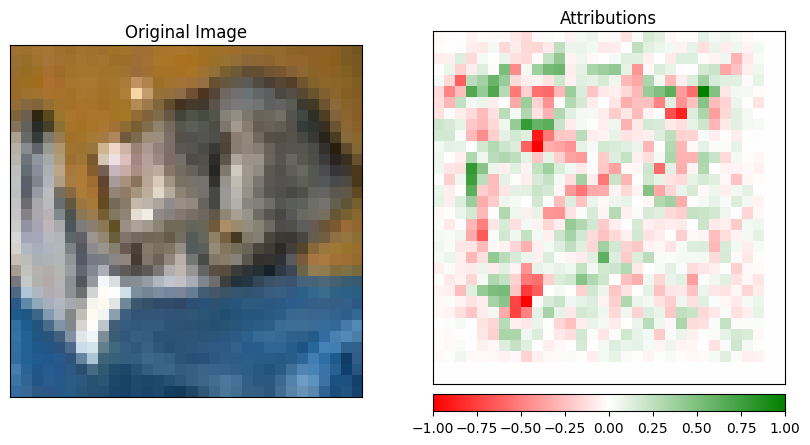

In [ ]:
# create an IntegratedGradients instance
ing = IntegratedGradients(model=cnn_model)

# pick a test instance - first image
x_explain = x_test_k[0:1]  # Select a single instance to explain, must be in 4D format (batch_size, height, width, channels)

# convert the true label of the instance to int32 to avoid type issues
y_target = y_test[0].astype('int32')

# compute the integrated gradients for the selected instance
explanation = ing.explain(x_explain, target=y_target)

# get attributions for the explained instance
attrs = explanation.attributions[0]

# create subplots to visualize the original image and the attributions
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# visualize the original image
visualize_image_attr(attr=None, original_image=x_explain[0], method='original_image',
                     title='Original Image', plt_fig_axis=(fig, ax[0]), use_pyplot=False)  # Plot the original image

# visualize the attributions as a heatmap
visualize_image_attr(attr=attrs.squeeze(), original_image=x_explain[0], method='heat_map',
                     sign='all', show_colorbar=True, title='Attributions',
                     plt_fig_axis=(fig, ax[1]), use_pyplot=True)  # Plot the attributions as a heatmap


plt.show()

### b. Discuss the results obtained.

**The map obtained from Integrated Gradients highlights key areas of focus in the model's prediction.**

**Green regions represent positive contributions, indicating that the model relies on meaningful features such as the cat's face, fur patterns, or visible edges, showing that it is learning relevant visual patterns.**

**Red regions signify negative contributions, suggesting features that take away from the prediction; if these overlap with the cat, it may indicate confusion or biases, whereas red in the background (e.g., the blue blanket) shows the model correctly ignoring irrelevant parts.**

**The intensity of these contributions is proportional to their importance, with strong green intensities on the cat's face or ears confirming reliance on critical features, while scattered regions may indicate noise.**

## 2. Grad-CAM

### a. Implement Grad-CAM to visualise where the CNN is focusing during its predictions.

In [ ]:
# Grad-CAM Implementation
def grad_cam(model, img, layer_name='conv2d_1'):
    grad_model = Model(inputs=model.inputs, outputs=[model.get_layer(layer_name).output, model.output])
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img)
        class_idx = tf.argmax(predictions[0])
        loss = predictions[:, class_idx]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]
    heatmap = tf.reduce_sum(tf.multiply(pooled_grads, conv_outputs), axis=-1)

    heatmap = np.maximum(heatmap, 0)  # ReLU
    heatmap /= (np.max(heatmap) + 1e-8)  # Normalize for numerical stability

    return heatmap

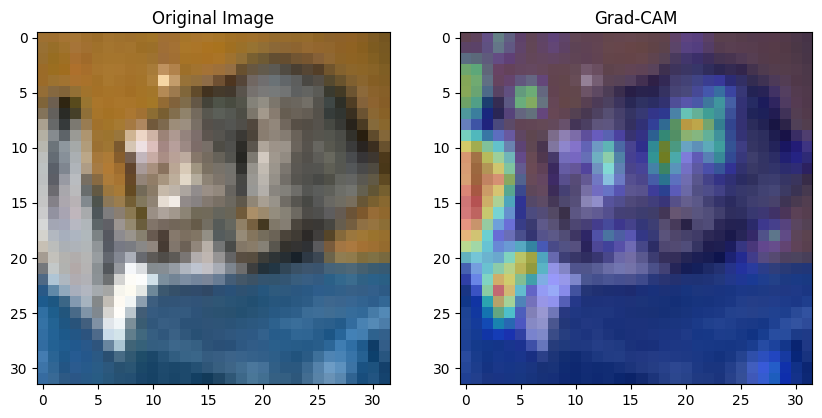

In [ ]:
# Choose an image to visualize
sample_img = x_test_k[0:1]

# Generate Grad-CAM heatmap
heatmap = grad_cam(cnn_model, sample_img, layer_name='conv2d_1')

# Convert the heatmap to the original image size
heatmap_resized = cv2.resize(heatmap, (32, 32))
heatmap_resized = np.uint8(255 * heatmap_resized)
heatmap_color = cv2.applyColorMap(heatmap_resized, cv2.COLORMAP_JET)

# Ensure sample_img[0] is also in uint8 for proper overlay
original_img_uint8 = np.uint8(255 * sample_img[0])

# Superimpose the heatmap on the original image
superimposed_img = cv2.addWeighted(cv2.cvtColor(original_img_uint8, cv2.COLOR_RGB2BGR), 0.6, heatmap_color, 0.4, 0)

# Display original and Grad-CAM visualization
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(x_test[0])  # Original unnormalized image
plt.title('Original Image')
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
plt.title('Grad-CAM')
plt.show()

### b. Discuss the results obtained.

**The Grad-CAM provides insights into where the CNN focuses during its predictions with warm colors (red and yellow) showing areas that strongly influence the model's prediction, and cool colors (blue) indicating less relevance. In this case, the CNN seems to focus on specific parts of the cat, such as its face and body contours, aligning with intuitive visual features for identifying the object.**

**The model demonstrates a strong ability to identify salient features, particularly on the cat's face and key edges, suggesting it is learning meaningful representations. The focus on the cat's features, indicates high confidence in the prediction. Conversely, if the warm areas are diffuse or inconsistent, it could suggest less reliability.**